# HARI SIVAKUMAR

# This is my first web scraper. It is an extension of ideas introduced in Lecture 2 of Harvard's CS109 course from Fall 2015, and also of a project by [Jesse Steinweg-Woods](https://jessesw.com/Data-Science-Skills/)

# The goal of this project is to find out
## 1) How many data science jobs are currently available
## 2) Where most jobs are
## 3) Who are the big employers

### Disclaimer: Some of the code is adapted from  Lecture 2 of Harvard's CS109 course from Fall 2015

In [2]:
## all imports
from IPython.display import HTML
import numpy as np
import urllib2
import bs4 
import time
import operator
import socket
import cPickle
import re # regular expressions

from pandas import Series
import pandas as pd
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


## First, I create a BeautifulSoup object by scraping the first page obtained when searching indeed.com for "Data Scientist"

In [3]:
# Fixed url for job postings containing data scientist
url = 'http://www.indeed.com/jobs?q=data+scientist&l='
# read the website
source = urllib2.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source, 'html.parser')

## On that page, I find the piece of the HTML code that lists the total number of job results

In [4]:
job_count_string = bs_tree.find(id = 'searchCount').contents[0]
#print job_count_string
#Jobs 1 to 50 of 21,383

#print job_count_string.split()
#[u'Jobs', u'1', u'to', u'50', u'of', u'21,383']

#print job_count_string.split()[-1]
#21,383

#print type(job_count_string.split())
#<type 'list'>

jc = job_count_string.split()[-1]
jc = jc.replace(",", "")
print 'There are ' + jc + ' Data Scientist job openings'
jc = int(jc)

There are 21444 Data Scientist job openings


## It would seem that there are over 21,000 Data Scientist job openings!! 

## Since there are only 10 results per page, I scrape all the pages (page by page) to extract all the locations, company names, and links to the job postings. 

In [ ]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(jc/10.0))

# Lambda expressions return the value of the expression inside it.
# In this case, it will return a string with new line characters replaced by spaces.
rem_nl = lambda s: s.replace("\n", " ")

base_url = 'http://www.indeed.com'
job_links = []
location = [];
company_name = [];
job_title = [];
for i in range(num_pages): #do range(num_pages) if you want them all
    print 'Scraped page ' + str(i+1)
    url = base_url + '/jobs?q=data+scientist&start=' + str(i*10)
    html_page = urllib2.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    
    # id = resultsCol is the attribute where the search results are
    job_link_area = bs_tree.find(id = 'resultsCol')
    
    # extracting all the job postings and putting them into the list when they are of class row result.
    # The reason it is done this way is because some of them are of class "row result" and others of class
    # " row result" with a whitespace, making it weird for beautiful soup. 
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                     and ''.join(jp.get('class')) =="rowresult"]
    
    # extract the job ids in the posting which have attribute data-jk
    job_ids = [jp.get('data-jk') for jp in job_postings];

    # extracting location which has heading span and attribute location. Need to check if any of them have weird
    # whitespaces, in which case the above method might be better
    # get text gives us the text inside <span class = location
    locations_this_page = [str(jp.find("span","location").get_text()) for jp in job_postings];
    
    # Same thing for company names, except get_text gives us something with \n new lines and white spaces. 
    # So we use the rem_nl method to remove the new lines and the strip() to remove white spaces
    company_names_this_page = [str(rem_nl(jp.find("span",{"company","a"}).get_text())).strip() for jp in job_postings]    
    
    # go after each link
    for id in job_ids:
        job_links.append(base_url + '/rc/clk?jk=' + id)
    # Append all the job locations from this page
    for loc in locations_this_page:
        location.append(loc)
    # Append all the company names from this page
    for cn in company_names_this_page:
        company_name.append(cn)

## The job locations are not always available in a consistent format. Sometimes, jobs are remote and other times, location is listed as "United States". Sometimes, the state is given but not the city. At first, I tried to account for all cases but it got a bit tiresome, so I decided to just remove data points for which the city and state were both not available

In [106]:
# Was planning to account for all cases, but there are too many

# for i in xrange(len(location)):
#     if location[i] == 'Remote':
#         location[i] = 'Remote, NS'
#     elif location[i] == 'United States':
#         location[i] = 'USA, NS'

# So if the format is not city, state, I'm throwing away the data

tmp = [loc.split(',') for loc in location]
del_idx = [];

# First, I get all the indices where the locations are not of format A , B 

for i in range(len(tmp)):
    x = tmp[i]
    if len(x) == 1:
        del_idx.append(i)

# An alternative way to do it based on try except

# for i in range(len(tmp)):
#     x = tmp[i]
#     try:
#         x[1]
#     except:
#         del_idx.append(i)


# Now delete all elements that are in del_idx from job_links, location and company name

del_set = set(del_idx)
job_links = [v for i, v in enumerate(job_links) if i not in del_set]
location = [v for i, v in enumerate(location) if i not in del_set]
company_name = [v for i, v in enumerate(company_name) if i not in del_set]



# for each location, split it by the comma. Then the first (0th) element is the city name
city = [loc.split(',')[0] for loc in location]

# The second (1th) element is the state. This could have garbage, so we just get the first 2 letters which is the
# state code
state = [loc.split(',')[1].strip()[0:2] for loc in location]

Scraped page 1
Scraped page 2
Scraped page 3
Scraped page 4
Scraped page 5
Scraped page 6
Scraped page 7
Scraped page 8
Scraped page 9
Scraped page 10
Scraped page 11
Scraped page 12
Scraped page 13
Scraped page 14
Scraped page 15
Scraped page 16
Scraped page 17
Scraped page 18
Scraped page 19
Scraped page 20
Scraped page 21
Scraped page 22
Scraped page 23
Scraped page 24
Scraped page 25
Scraped page 26
Scraped page 27
Scraped page 28
Scraped page 29
Scraped page 30
Scraped page 31
Scraped page 32
Scraped page 33
Scraped page 34
Scraped page 35
Scraped page 36
Scraped page 37
Scraped page 38
Scraped page 39
Scraped page 40
Scraped page 41
Scraped page 42
Scraped page 43
Scraped page 44
Scraped page 45
Scraped page 46
Scraped page 47
Scraped page 48
Scraped page 49
Scraped page 50
Scraped page 51
Scraped page 52
Scraped page 53
Scraped page 54
Scraped page 55
Scraped page 56
Scraped page 57
Scraped page 58
Scraped page 59
Scraped page 60
Scraped page 61
Scraped page 62
Scraped page 63
S

## Having scraped all this data, I first use cPickle to store it so I don't lose it!

In [109]:
with open('data/hari_scraped_job_links', 'wb') as f:
    cPickle.dump(job_links, f)
with open('data/hari_scraped_locations', 'wb') as f:
    cPickle.dump(location, f)
with open('data/hari_company_names', 'wb') as f:
    cPickle.dump(company_name, f)

## So let's take a look at all the jobs we scraped!

In [189]:
scraped_dict = {"Company Name": company_name, "City": city, "State": state, "Link": job_links}
df = pd.DataFrame(scraped_dict)
df

,City,Company Name,Link,State
0,Las Vegas,"Zappos.com, Inc.",http://www.indeed.com/rc/clk?jk=528e68ca0f0b6ee6,NV
1,San Diego,CoreLogic,http://www.indeed.com/rc/clk?jk=805e18fb46de32d2,CA
2,Santa Barbara,Impact Radius,http://www.indeed.com/rc/clk?jk=49d6292eef337b95,CA
3,Greenbelt,"ADNET Systems, Inc.",http://www.indeed.com/rc/clk?jk=ed9e8730311006f8,MD
4,Sunnyvale,Jetlore,http://www.indeed.com/rc/clk?jk=216ae49d6d9fcc5f,CA
5,New York,SecurityScorecard,http://www.indeed.com/rc/clk?jk=f9a029994aedd666,NY
6,Bellevue,Neal Analytics,http://www.indeed.com/rc/clk?jk=f8cb12e46b469b9e,WA
7,Atlanta,SunTrust,http://www.indeed.com/rc/clk?jk=d2d092c980db01b6,GA
8,Bellevue,Concordis,http://www.indeed.com/rc/clk?jk=7a2f5abcc61080a0,WA
9,Columbus,JPMorgan Chase,http://www.indeed.com/rc/clk?jk=d9d6a39b236870c0,OH


## There still seem to be over 19,000 jobs after removing the data without location in the correct format

In [190]:
df.describe()

,City,Company Name,Link,State
count,19367,19367,19367,19367
unique,279,658,789,46
top,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,CA
freq,2045,2045,2045,3179


## It is somewhat odd that this company Syngenta is hiring 2045 data scientists! It is possible that this company is based in this city called Stanton, since they both have 2045 results.  A single company with 2045 data scientist positions?? Let's investigate!

In [198]:
df[df.City == 'Stanton'].head(20)

,City,Company Name,Link,State
963,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,MN
972,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,MN
983,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,MN
990,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,MN
1001,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,MN
1008,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,MN
1016,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,MN
1028,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,MN
1037,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,MN
1044,Stanton,Syngenta,http://www.indeed.com/rc/clk?jk=8d11e7ad1eed279a,MN


## Ah-hah, mystery solved! We see that the job link in each of these 2045 job postings is exactly the same. So really, it is 2045 ads for the same (single) job with Syngenta. This probably means that there are plenty of duplicates in our data

In [200]:
df2 = df.drop_duplicates()
df2

,City,Company Name,Link,State
0,Las Vegas,"Zappos.com, Inc.",http://www.indeed.com/rc/clk?jk=528e68ca0f0b6ee6,NV
1,San Diego,CoreLogic,http://www.indeed.com/rc/clk?jk=805e18fb46de32d2,CA
2,Santa Barbara,Impact Radius,http://www.indeed.com/rc/clk?jk=49d6292eef337b95,CA
3,Greenbelt,"ADNET Systems, Inc.",http://www.indeed.com/rc/clk?jk=ed9e8730311006f8,MD
4,Sunnyvale,Jetlore,http://www.indeed.com/rc/clk?jk=216ae49d6d9fcc5f,CA
5,New York,SecurityScorecard,http://www.indeed.com/rc/clk?jk=f9a029994aedd666,NY
6,Bellevue,Neal Analytics,http://www.indeed.com/rc/clk?jk=f8cb12e46b469b9e,WA
7,Atlanta,SunTrust,http://www.indeed.com/rc/clk?jk=d2d092c980db01b6,GA
8,Bellevue,Concordis,http://www.indeed.com/rc/clk?jk=7a2f5abcc61080a0,WA
9,Columbus,JPMorgan Chase,http://www.indeed.com/rc/clk?jk=d9d6a39b236870c0,OH


## Having dropped all the duplicates, it turns out that there are really only 789 job postings for data scientist :(

### This could also have been seen if we had observed the number of unique job ids in df.describe()

In [123]:
df2.describe()

,City,Company Name,Link,State
count,789,789,789,789
unique,279,658,789,46
top,New York,Apple,http://www.indeed.com/rc/clk?jk=0c4a42ae2bde0647,CA
freq,49,9,1,189


## NYC has at least 49 job openings, while Apple has 9 open data scientist positions. We can verify that each of these jobs is a unique opening

In [124]:
df2[df2['Company Name'] == 'Apple']

,City,Company Name,Link,State
26,Santa Clara Valley,Apple,http://www.indeed.com/rc/clk?jk=389ee2e7c36467d2,CA
229,Santa Clara Valley,Apple,http://www.indeed.com/rc/clk?jk=162f17321fba22aa,CA
282,Santa Clara Valley,Apple,http://www.indeed.com/rc/clk?jk=86489240a6f6aa6c,CA
653,San Francisco,Apple,http://www.indeed.com/rc/clk?jk=584c5fbba3fbf8ae,CA
702,Santa Clara Valley,Apple,http://www.indeed.com/rc/clk?jk=2f75bcad6b7ec1ef,CA
768,Santa Clara Valley,Apple,http://www.indeed.com/rc/clk?jk=63314403426d0899,CA
882,Santa Clara Valley,Apple,http://www.indeed.com/rc/clk?jk=41fbd1fbc89d2a69,CA
985,Santa Clara Valley,Apple,http://www.indeed.com/rc/clk?jk=290e8e6f4e512561,CA
1024,Santa Clara Valley,Apple,http://www.indeed.com/rc/clk?jk=abd6fe919f1e27eb,CA


## Let's see the distribution jobs by state, for the top 20 states

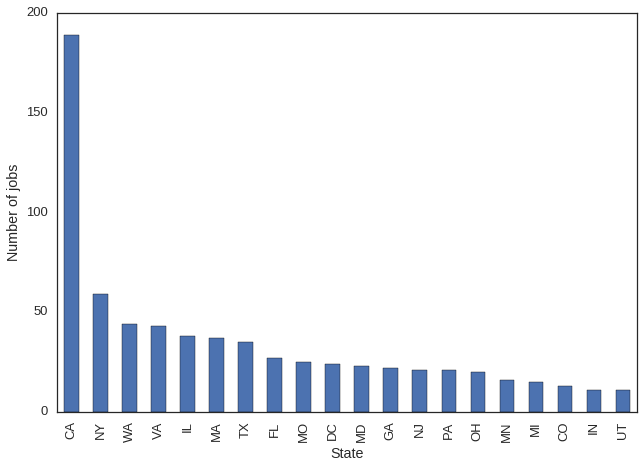

In [204]:
grouped_by_state = df2.groupby('State')['Company Name']
# df.groupby('A') is just syntactic sugar for df.groupby(df['A'])
num_jobs_per_state = grouped_by_state.count().sort_values(ascending=False)
num_jobs_per_state[0:20].plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Number of jobs')

## And also the top hirers

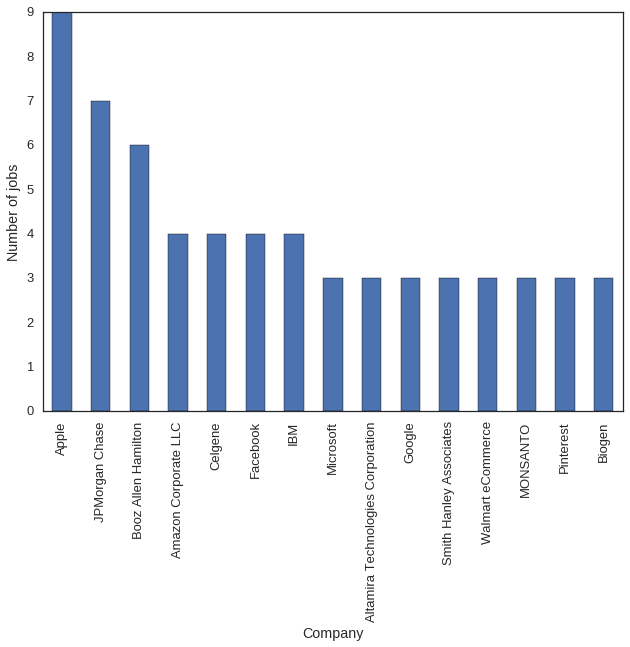

In [205]:
grouped_by_cn = df2.groupby('Company Name')['Link']
# df.groupby('A') is just syntactic sugar for df.groupby(df['A'])
num_jobs_per_cn = grouped_by_cn.count().sort_values(ascending=False)
num_jobs_per_cn[:15].plot(kind='bar')
plt.xlabel('Company')
plt.ylabel('Number of jobs')

## Some data for my own perusal

In [125]:
df2[df2['State'] == 'NC']

,City,Company Name,Link,State
71,Morrisville,MaxPoint,http://www.indeed.com/rc/clk?jk=401165ae15083eea,NC
184,Raleigh,Capital Bank,http://www.indeed.com/rc/clk?jk=a9a1683f2fd77e02,NC
230,Charlotte,TIAA,http://www.indeed.com/rc/clk?jk=52798a59c9b1397d,NC
281,Charlotte,U.S. Bank,http://www.indeed.com/rc/clk?jk=cafaa123d236642d,NC
377,Mooresville,Lowe's,http://www.indeed.com/rc/clk?jk=af640828b929a15a,NC
443,Charlotte,UTC,http://www.indeed.com/rc/clk?jk=8fbb850183563c9e,NC
539,Morrisville,Direct Client,http://www.indeed.com/rc/clk?jk=be217a513d5f7b62,NC
565,Raleigh,North Carolina State University,http://www.indeed.com/rc/clk?jk=54723054849ae705,NC
958,Morrisville,PHASTAR,http://www.indeed.com/rc/clk?jk=022da113034486f6,NC


In [126]:
df2[df2['Company Name'] == 'IBM']

,City,Company Name,Link,State
81,Washington,IBM,http://www.indeed.com/rc/clk?jk=9f28346a5152e4fe,DC
641,Washington,IBM,http://www.indeed.com/rc/clk?jk=edf4480b47755e05,DC
645,Cleveland,IBM,http://www.indeed.com/rc/clk?jk=927410f8de15b6e6,OH
703,Austin,IBM,http://www.indeed.com/rc/clk?jk=7efb7e6833b325c8,TX


# Future work

## There are some interesting future steps we can take
### 1) We can obtain data of zip codes associated with each city, and plot a heatmap of jobs within the US, possibly using Kernel Density Estimation
### 2) We can classify the locations by broader headings (e.g. Santa Clara, Sunnyvale etc ==> South Bay, Los Angeles, Irvine, etc ==> Greater LA, Seattle, Bellevue, Redmond ==> Greater Seattle). This would give a more accurate distribution of where the jobs are
### 3) We can then scrape the job links for different skills that employers are looking for. Based on the classifications from (2), we can see if there is a pattern between the location of job and the skills required. 
#### skills e.g. : skill_set = {'mapreduce': 0, 'spark': 0, 'hadoop': 0, 'R': 0, 'python': 0}